# Prédiction de l'âge d'un opossum à l'aide de la régression

Un groupe de zoologistes vous fournit une dataset regroupant les caractéristiques d'opossums qu'ils ont étudiés et vous demande un programme capable de prédire l'âge d'un opossum à partir de ses caractéristiques.

# 1) Mise en place de l'environnementde travail
## a) Import des librairies necessaires

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

## b) Chargement du dataset

In [69]:
df = pd.read_csv('possum.csv')
df.head()

,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


# 2) Nettoyage

In [70]:
df.isnull().sum()

case        0
site        0
Pop         0
sex         0
age         2
hdlngth     0
skullw      0
totlngth    0
taill       0
footlgth    1
earconch    0
eye         0
chest       0
belly       0
dtype: int64

On a des valeurs nulles qu'on va remplacer par la médiane

In [71]:
imp_median = SimpleImputer(missing_values=pd.NA, strategy='median')
df[['age', 'footlgth']] = imp_median.fit_transform(df[['age', 'footlgth']])

On décide aussi de drop la colonne `case` qui n'apporte aucune information utile

In [72]:
df.drop(['case'], axis=1, inplace=True)
df.head()

,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


# 3) Analyse Exploratoire des Données (AED)
## a) Visualisation numérique

In [73]:
df['age'].describe().to_frame()

,age
count,104.000000
mean,3.817308
std,1.894112
min,1.000000
25%,2.750000
50%,3.000000
75%,5.000000
max,9.000000


L'âge est compris entre 1 et 9 ans et l'âge moyen est de 3.8 ans

In [74]:
df['sex'].value_counts().to_frame()

,sex
m,61
f,43


Relativement bonne répartition des genres

In [75]:
df['age'].value_counts().to_frame()

,age
3.0,29
2.0,16
4.0,14
5.0,13
6.0,12
1.0,10
7.0,7
9.0,2
8.0,1


L'âge quand a lui est moins bien reparti

## b) Visualisation graphique
### *Variables catégoriques :*

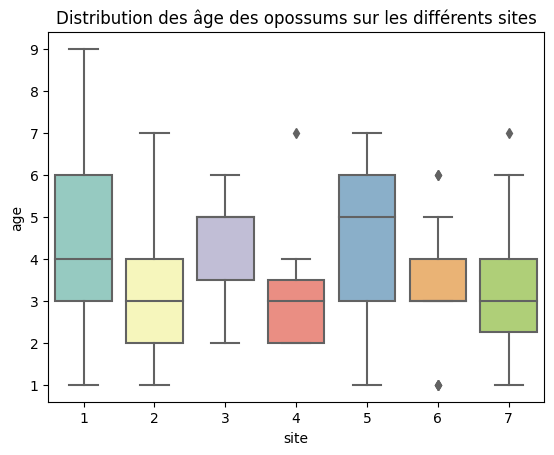

In [76]:
plt.figure()
sns.boxplot(x="site", y="age", data=df ,palette="Set3")
plt.title("Distribution des âge des opossums sur les différents sites")
plt.show()

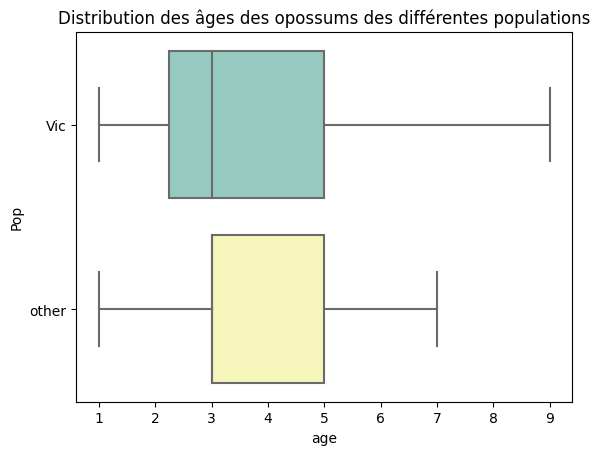

In [77]:
plt.figure()
sns.boxplot(x = "age", y = "Pop", data = df, palette = "Set3")
plt.title("Distribution des âges des opossums des différentes populations")
plt.show()

##### *Observations :* 

L'âge médian d'un opossum mâle est inférieur à celui d'une femelle

Plus grande variation des âges dans Vic

### *Variables numériques :*

In [78]:
df.head()

,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


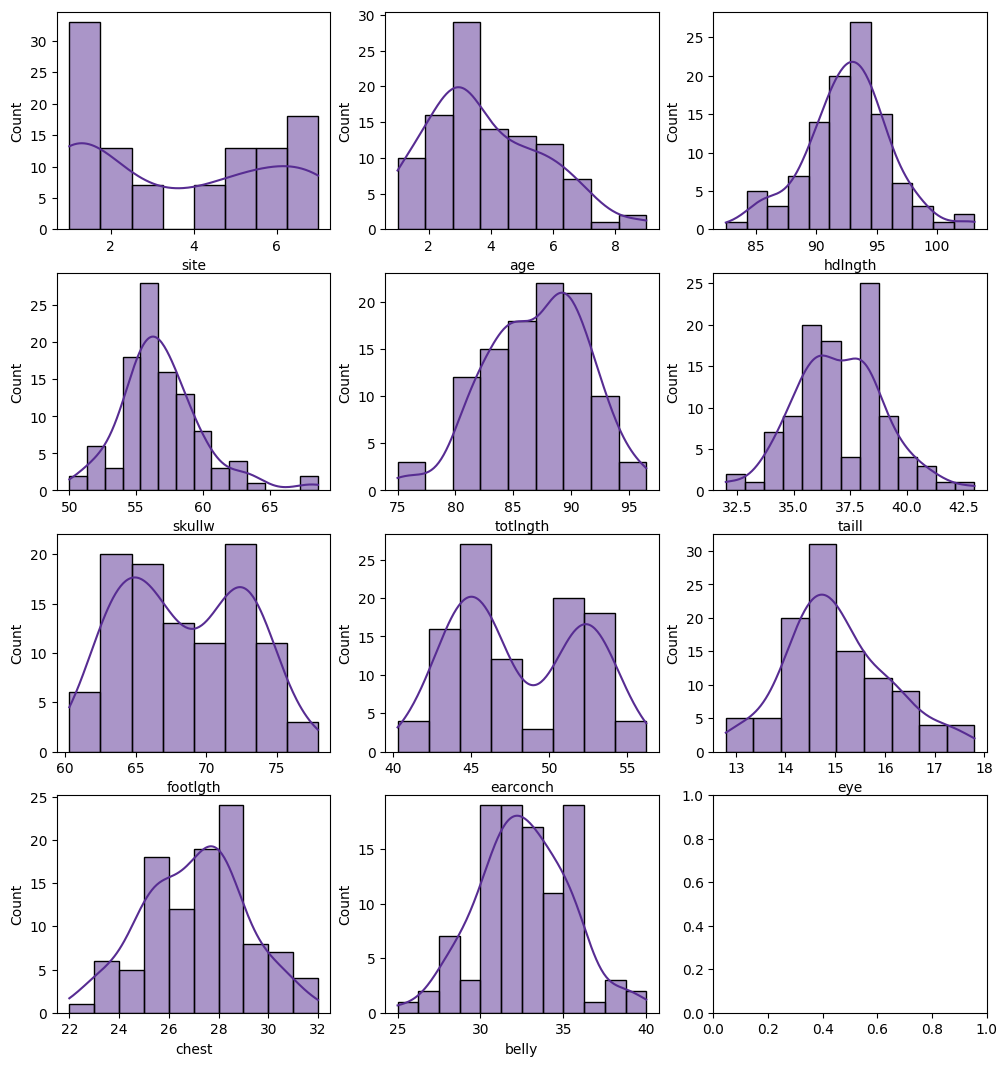

In [79]:
numerical_features = df.drop(['Pop', 'sex'], axis=1)
sns.set_palette('Purples_r')
fig, ax = plt.subplots(4, 3, figsize=(12,13))
for i, col in enumerate(numerical_features):
    sns.histplot(df[col], kde=True, ax=ax[i//3, i%3])
plt.show()

## c) Outliers

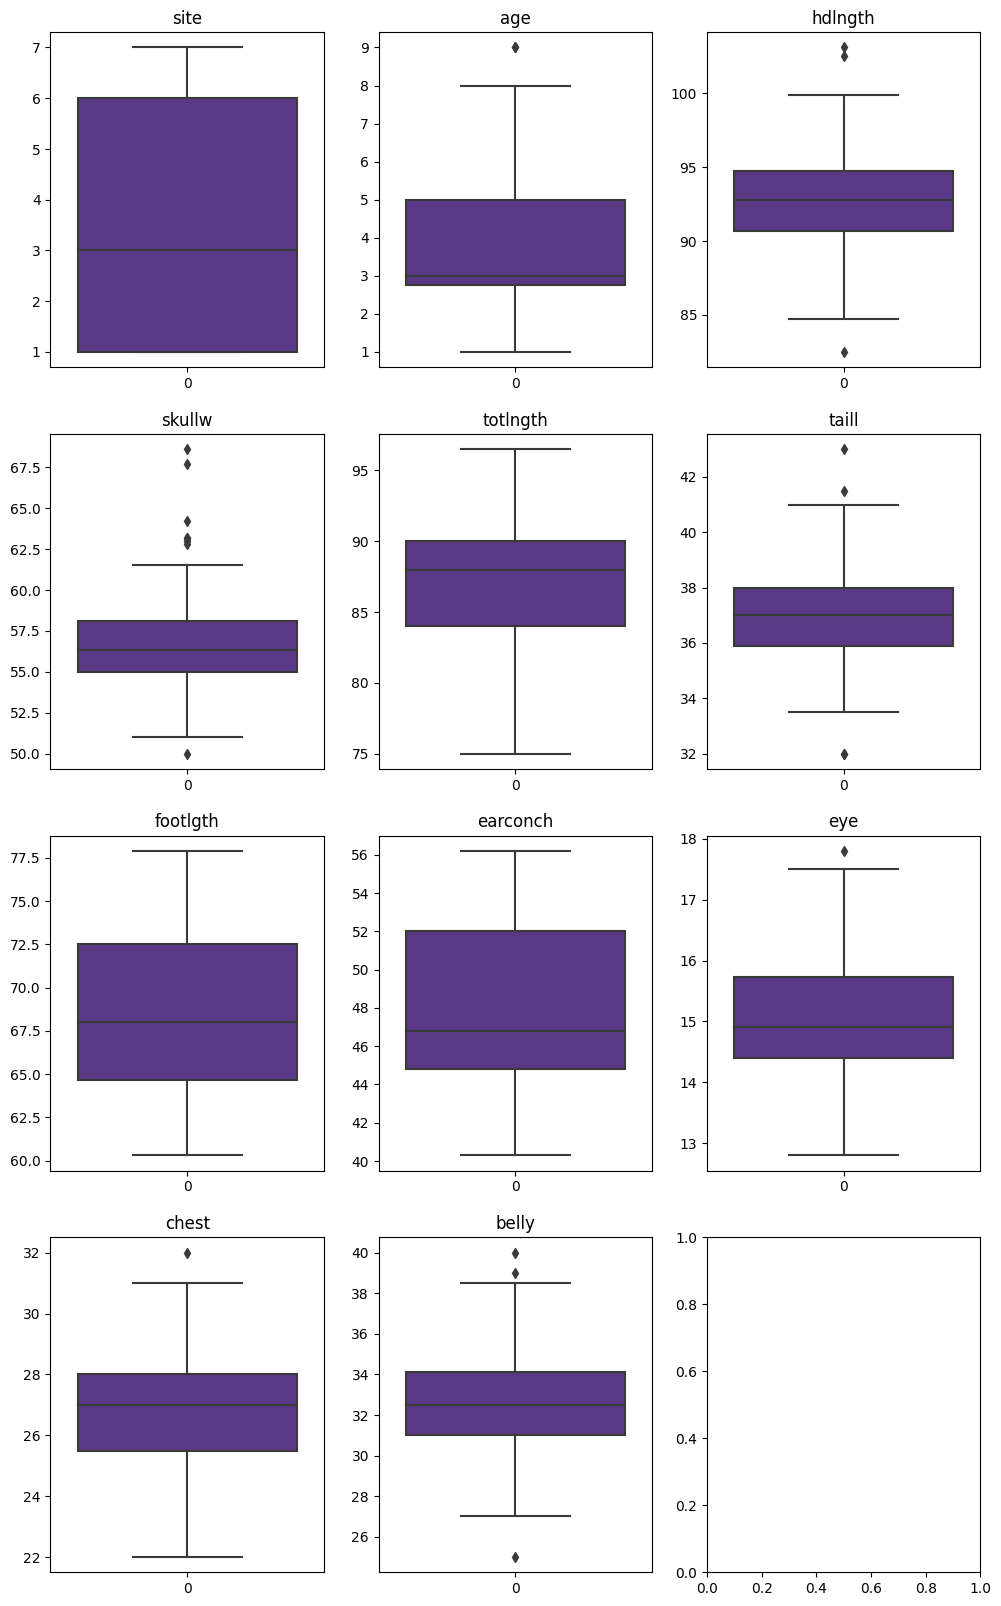

In [80]:
sns.set_palette('Purples_r')
fig, ax = plt.subplots(4,3, figsize=(12,20))
for i, col in enumerate(numerical_features):
    ax[i//3, i%3].set_title(col)
    sns.boxplot(data=df[col], ax=ax[i//3, i%3])
    

`hdlngth`, `skullw`, `taill`, `chest` et `belly` contiennent des valeurs aberrantes

*Gestion des outliers :*

In [81]:
mask1 = df.loc[:,'hdlngth'] > 100
mask2 = df.loc[:,'skullw'] > 63
mask3 = df.loc[:,'taill'] > 42.5
mask4 = df.loc[:,'chest'] > 31
mask5 = df.loc[:,'belly'] < 21

#On remplace par la médiane
df.loc[mask1, 'hdlngth'] = df['hdlngth'].median()
df.loc[mask2, 'skullw'] = df['skullw'].median()
df.loc[mask3, 'taill'] = df['taill'].median()
df.loc[mask4, 'chest'] = df['chest'].median()
df.loc[mask5, 'belly'] = df['belly'].median()

## d) Correlation

On va désormais encoder `Pop` et `sex` pour pouvoir visualiser leurs corrélations

In [82]:
le = LabelEncoder()
df['Pop'] = le.fit_transform(df.Pop) #Pop = 0 --> Vic      Pop = 1 --> other
pop_classes = le.classes_
df['sex'] = le.fit_transform(df.sex) #sex = 0 --> male     sex = 1 --> female
sex_classes = le.classes_
df.head()

,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,0,1,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,1,0,0,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,1,0,0,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,1,0,0,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,1,0,0,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


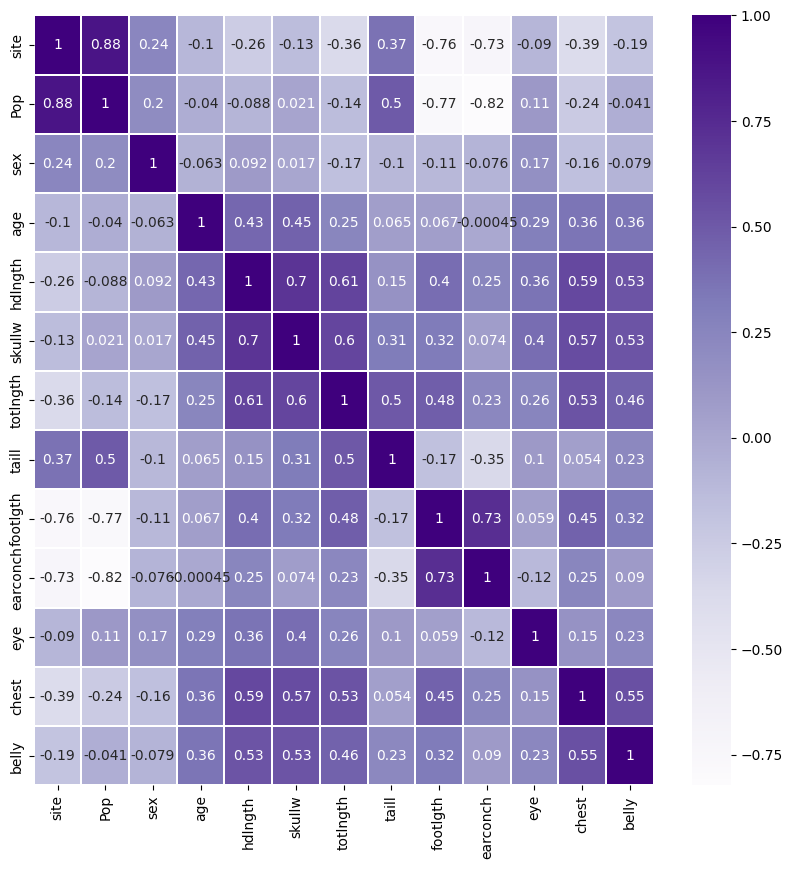

In [83]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(method='spearman'), annot=True, cmap='Purples', linewidths=0.2, annot_kws={'size':10})
plt.show()

On drop `earconch`, `footlgth`, `taill`, `sex`, `pop`, `site` qui n'ont quasiment aucune correlation avec la sortie `age`

In [84]:
df.drop(['earconch'], axis=1, inplace=True)
df.drop(['footlgth'], axis=1, inplace=True)
df.drop(['taill'], axis=1, inplace=True)
df.drop(['sex'], axis=1, inplace=True)
df.drop(['Pop'], axis=1, inplace=True)
df.drop(['site'], axis=1, inplace=True)
df.head() 

,age,hdlngth,skullw,totlngth,eye,chest,belly
0,8.0,94.1,60.4,89.0,15.2,28.0,36.0
1,6.0,92.5,57.6,91.5,16.0,28.5,33.0
2,6.0,94.0,60.0,95.5,15.5,30.0,34.0
3,6.0,93.2,57.1,92.0,15.2,28.0,34.0
4,2.0,91.5,56.3,85.5,15.1,28.5,33.0


# 6) Splitter le dataset

In [85]:
y = df['age']
X = df.drop('age', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7) Mise à l'échelle

In [86]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

# 8) Choix du modèle

### **Regression linéaire**

In [87]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train_scale, y_train)

LinearRegression()

*Score du modèle :*

In [88]:
lin_reg_y_pred = lin_reg_model.predict(X_test_scale)

lin_reg_rmse = np.sqrt(mean_squared_error(lin_reg_y_pred, y_test))
lin_reg_r2 = r2_score(y_test, lin_reg_y_pred)
print("Coefficients :", lin_reg_model.coef_)
print("Root mean square error :",lin_reg_rmse)
print("R² score :",lin_reg_r2)

Coefficients : [ 0.32944118  0.31137333 -0.18111154  0.18563092  0.05863166  0.18426295]
Root mean square error : 1.7218572939533499
R² score : 0.3501622711399127


### **KNN Regressor**
*Choix des meilleurs hyper-paramètres* :

In [97]:
param_grid = {'n_neighbors' : np.arange(1,50), 'metric' : ['euclidean', 'manhattan', 'minkowski']}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=cv)
grid.fit(X_train_scale, y_train)
grid.best_params_

/home/zile/iadev-python/py-sql/.venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


{'metric': 'manhattan', 'n_neighbors': 32}

*Score du modèle :*

In [98]:
KNN_regressor = grid.best_estimator_
KNN_y_pred = KNN_regressor.predict(X_test_scale)

KNN_rmse = np.sqrt(mean_squared_error(y_test, KNN_y_pred))
KNN_r2 = r2_score(y_test, KNN_y_pred)
print("Root mean square error :", KNN_rmse)
print("R² score : ", KNN_r2)

Root mean square error : 1.9214000816616834
R² score :  0.19081798272862827


### **Regression polynomiale**
*Création des features polynomiales :*

In [236]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X)

*Split et mise à l'échelle du nouveau jeu de données :*

In [237]:
poly_X_train, poly_X_test, poly_y_train, poly_y_test = train_test_split(poly_features, y, test_size=0.2, random_state=42)
scaler_poly = StandardScaler()
poly_X_train_scale = scaler_poly.fit_transform(poly_X_train)
poly_X_test_scale = scaler_poly.transform(poly_X_test)

*Création du modèle polynomial :*

In [238]:
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_X_train_scale, poly_y_train)

LinearRegression()

*Score du modèle :*

In [239]:
poly_reg_y_pred = poly_reg_model.predict(poly_X_test_scale)

poly_reg_rmse = np.sqrt(mean_squared_error(poly_y_test, poly_reg_y_pred))
poly_reg_r2 = r2_score(poly_y_test, poly_reg_y_pred)
print("Coefficients :", poly_reg_model.coef_)
print("Root mean square error :", poly_reg_rmse)
print("R² score : ", poly_reg_r2)

Coefficients : [ 27.50840496  -3.36516629 -10.59834028  11.40878363   2.7026834
   0.74510794 -21.32705426  19.00972317   0.32580838 -26.02780088
  -9.40921756  -1.97442913  -8.06113628 -28.7307756   -2.42477021
  26.48458603  13.10246543  18.38514434   8.41033511  21.61405086
 -13.65431036   5.06567812   0.92440295  -1.75400762 -31.31701963
   3.08855806   0.07038747]
Root mean square error : 2.516719356183566
R² score :  -0.3882899881436177


R² est négatif, cela signifie que le modèle performe moins bien qu'une ligne horizontale

**Au final :** Le modèle le plus performant est *LinearResgression*

# 9) Sauvegarde du modèle et du scaler

In [240]:
joblib.dump(lin_reg_model, 'final_model')
joblib.dump(scaler, 'scaler')

['scaler']